In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import catboost, sklearn, imblearn, matplotlib, plotly
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import plotly.express as px
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
import h2o
from h2o.automl import H2OAutoML
import shap

In [2]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(matplotlib.__version__)
print(plotly.__version__)
print(catboost.__version__)
print(sklearn.__version__)
print(imblearn.__version__)
print(h2o.__version__)
print(shap.__version__)

1.5.1
1.23.4
0.12.2
3.7.2
5.17.0
1.2.2
1.3.1
0.11.0
3.44.0.2
0.43.0


Версии библиотек

1.5.1

1.23.5

0.12.2

3.7.3

5.17.0

1.2.2

1.3.1

0.11.0

3.44.0.2

0.43.0

In [3]:
with open("32_052019.xlsx", "rb") as file:
  df = pd.read_excel(file)

## EDA

In [4]:
df

,Код станции отправления,Станция отправления,Регион отгрузки,Ж/Д отгрузки,Отд. ж/д отгрузки,Код станции назначения,Станция назначения,Регион поставки,Ж/Д поставки,Отд. ж/д поставки,...,Станция отправления загран,Код станции отправления загран,Станция назначения загран,Код станции назначения загран,Отч мес,Отч год,Код страны отправления,Страна отправления,Код страны назначения,Страна назначения
0,86420,НОВОКУЗНЕЦК-СЕВЕРНЫЙ,КЕМЕРОВСКАЯ ОБЛАСТЬ,Западно-Сибирская,HОВОКУЗHЕЦ-Е,84480,КУЛУНДА-ЭКСПОРТ (В КАЗ),АЛТАЙСКИЙ КРАЙ,Западно-Сибирская,АЛТАЙСКОЕ,...,НОВОКУЗ.-СЕВ,86420,БИШКЕК 1,71660,5,19,643,РОССИЯ,417,КИРГИЗИЯ
1,86420,НОВОКУЗНЕЦК-СЕВЕРНЫЙ,КЕМЕРОВСКАЯ ОБЛАСТЬ,Западно-Сибирская,HОВОКУЗHЕЦ-Е,84480,КУЛУНДА-ЭКСПОРТ (В КАЗ),АЛТАЙСКИЙ КРАЙ,Западно-Сибирская,АЛТАЙСКОЕ,...,НОВОКУЗ.-СЕВ,86420,БИШКЕК 1,71660,5,19,643,РОССИЯ,417,КИРГИЗИЯ
2,86420,НОВОКУЗНЕЦК-СЕВЕРНЫЙ,КЕМЕРОВСКАЯ ОБЛАСТЬ,Западно-Сибирская,HОВОКУЗHЕЦ-Е,84480,КУЛУНДА-ЭКСПОРТ (В КАЗ),АЛТАЙСКИЙ КРАЙ,Западно-Сибирская,АЛТАЙСКОЕ,...,НОВОКУЗ.-СЕВ,86420,БИШКЕК 1,71660,5,19,643,РОССИЯ,417,КИРГИЗИЯ
3,86420,НОВОКУЗНЕЦК-СЕВЕРНЫЙ,КЕМЕРОВСКАЯ ОБЛАСТЬ,Западно-Сибирская,HОВОКУЗHЕЦ-Е,84480,КУЛУНДА-ЭКСПОРТ (В КАЗ),АЛТАЙСКИЙ КРАЙ,Западно-Сибирская,АЛТАЙСКОЕ,...,НОВОКУЗ.-СЕВ,86420,АКЖАЙЫК,66160,5,19,643,РОССИЯ,398,КАЗАХСТАН
4,86420,НОВОКУЗНЕЦК-СЕВЕРНЫЙ,КЕМЕРОВСКАЯ ОБЛАСТЬ,Западно-Сибирская,HОВОКУЗHЕЦ-Е,84480,КУЛУНДА-ЭКСПОРТ (В КАЗ),АЛТАЙСКИЙ КРАЙ,Западно-Сибирская,АЛТАЙСКОЕ,...,НОВОКУЗ.-СЕВ,86420,АКЖАЙЫК,66160,5,19,643,РОССИЯ,398,КАЗАХСТАН
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36188,93460,МЫСОВАЯ,РЕСПУБЛИКА БУРЯТИЯ,Восточно-Сибирская,УЛАH-УДЕH-ОЕ,93320,АНГАСОЛКА,ИРКУТСКАЯ ОБЛАСТЬ,Восточно-Сибирская,УЛАH-УДЕH-ОЕ,...,00000,0,00000,0,5,19,0,РОССИЯ,0,РОССИЯ
36189,93460,МЫСОВАЯ,РЕСПУБЛИКА БУРЯТИЯ,Восточно-Сибирская,УЛАH-УДЕH-ОЕ,93460,МЫСОВАЯ,РЕСПУБЛИКА БУРЯТИЯ,Восточно-Сибирская,УЛАH-УДЕH-ОЕ,...,00000,0,00000,0,5,19,0,РОССИЯ,0,РОССИЯ
36190,94960,ЗИЛОВО,ЧИТИНСКАЯ ОБЛАСТЬ,Забайкальская,МОГОЧИHСКОЕ,95050,СБЕГА,ЧИТИНСКАЯ ОБЛАСТЬ,Забайкальская,МОГОЧИHСКОЕ,...,00000,0,00000,0,5,19,0,РОССИЯ,0,РОССИЯ
36191,65540,ИГЛИНО,РЕСПУБЛИКА БАШКОРТОСТАН,Куйбышевская,БАШКИРСКОЕ,65540,ИГЛИНО,РЕСПУБЛИКА БАШКОРТОСТАН,Куйбышевская,БАШКИРСКОЕ,...,00000,0,00000,0,5,19,0,РОССИЯ,0,РОССИЯ


In [5]:
main_df = df[(df['Ж/Д отгрузки ']=='Московская') | (df['Ж/Д поставки ']=='Московская')]
main_df.columns = main_df.columns.str.strip()
main_df.reset_index(inplace=True, drop=True)

In [6]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7455 entries, 0 to 7454
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Код станции отправления         7455 non-null   int64  
 1   Станция отправления             7455 non-null   object 
 2   Регион отгрузки                 7455 non-null   object 
 3   Ж/Д отгрузки                    7455 non-null   object 
 4   Отд. ж/д отгрузки               7447 non-null   object 
 5   Код станции назначения          7455 non-null   int64  
 6   Станция назначения              7455 non-null   object 
 7   Регион поставки                 7455 non-null   object 
 8   Ж/Д поставки                    7455 non-null   object 
 9   Отд. ж/д поставки               7450 non-null   object 
 10  Код Клиента                     7455 non-null   int64  
 11  Клиент                          7455 non-null   object 
 12  Код отправителя груза           74

### Ищем и удаляем пропуски

<Axes: >

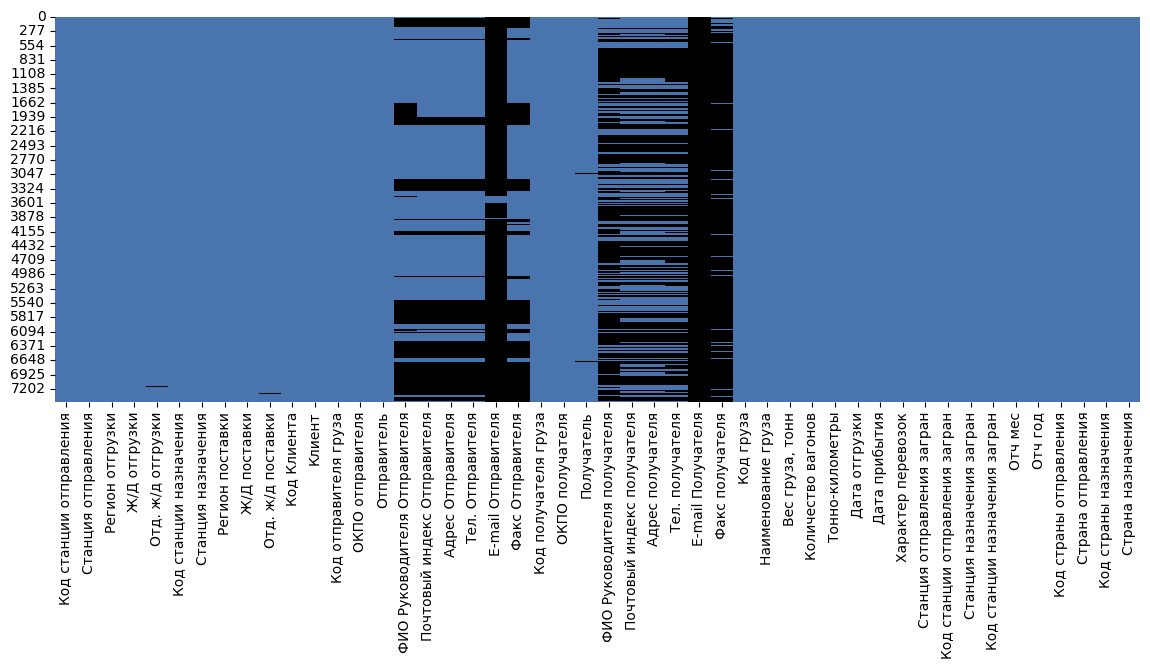

In [7]:
colours = ['#4974ad', '#000000']
plt.figure(figsize=(14, 5))
sns.heatmap(main_df.isnull(), cmap=sns.color_palette(colours), cbar=False)

In [8]:
df.isnull().mean() * 100

Код станции отправления            0.000000
Станция отправления                0.002763
Регион отгрузки                    0.002763
Ж/Д отгрузки                       0.002763
Отд. ж/д отгрузки                  0.298400
Код станции назначения             0.000000
Станция назначения                 0.002763
Регион поставки                    0.002763
Ж/Д поставки                       0.002763
Отд. ж/д поставки                  0.696267
Код Клиента                        0.000000
Клиент                             0.000000
Код отправителя груза              0.000000
ОКПО отправителя                   0.000000
Отправитель                        0.013815
ФИО Руководителя Отправителя      29.624513
Почтовый индекс Отправителя       24.932998
Адрес Отправителя                 24.932998
Тел. Отправителя                  25.214821
E-mail Отправителя                96.165004
Факс Отправителя                  33.489901
Код получателя груза               0.000000
ОКПО получателя                 

In [9]:
main_df.drop(columns=[
'ФИО Руководителя Отправителя',
'Почтовый индекс Отправителя',
'Адрес Отправителя',
'Тел. Отправителя',
'E-mail Отправителя',
'Факс Отправителя',
'ФИО Руководителя получателя',
'Почтовый индекс получателя',
'Адрес получателя',
'Тел. получателя',
'E-mail Получателя',
'Факс получателя',
'Отч мес', 
'Отч год'], inplace=True)
main_df.dropna(inplace=True)
main_df.drop_duplicates(inplace=True)
main_df.reset_index(inplace=True, drop=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
main_df.isnull().mean() * 100

Код станции отправления           0.0
Станция отправления               0.0
Регион отгрузки                   0.0
Ж/Д отгрузки                      0.0
Отд. ж/д отгрузки                 0.0
Код станции назначения            0.0
Станция назначения                0.0
Регион поставки                   0.0
Ж/Д поставки                      0.0
Отд. ж/д поставки                 0.0
Код Клиента                       0.0
Клиент                            0.0
Код отправителя груза             0.0
ОКПО отправителя                  0.0
Отправитель                       0.0
Код получателя груза              0.0
ОКПО получателя                   0.0
Получатель                        0.0
Код груза                         0.0
Наименование груза                0.0
Вес груза, тонн                   0.0
Количество вагонов                0.0
Тонно-километры                   0.0
Дата отгрузки                     0.0
Дата прибытия                     0.0
Характер перевозок                0.0
Станция отпр

### Преобразуем дату и находим длительность доставки

In [11]:
def change_format(x):
    x = str(x)
    x = x.rjust(4, '0')
    x = f"{x[:2]}-{x[2:]}"
    x = dt.datetime.strptime(x, '%d-%m')
    return x

In [12]:
main_df['Длительность доставки'] = (main_df['Дата прибытия'].apply(change_format) - main_df['Дата отгрузки'].apply(change_format)).dt.days
main_df['Длительность доставки']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0       22
1       26
2       16
3        8
4        8
        ..
7388     2
7389     2
7390     2
7391     1
7392     2
Name: Длительность доставки, Length: 7393, dtype: int64

In [15]:
main_df[['Дата прибытия', 'Дата отгрузки', 'Длительность доставки']]
main_df['Длительность доставки'].max()

50

### Визуализируем отношения между фичами

<Axes: >

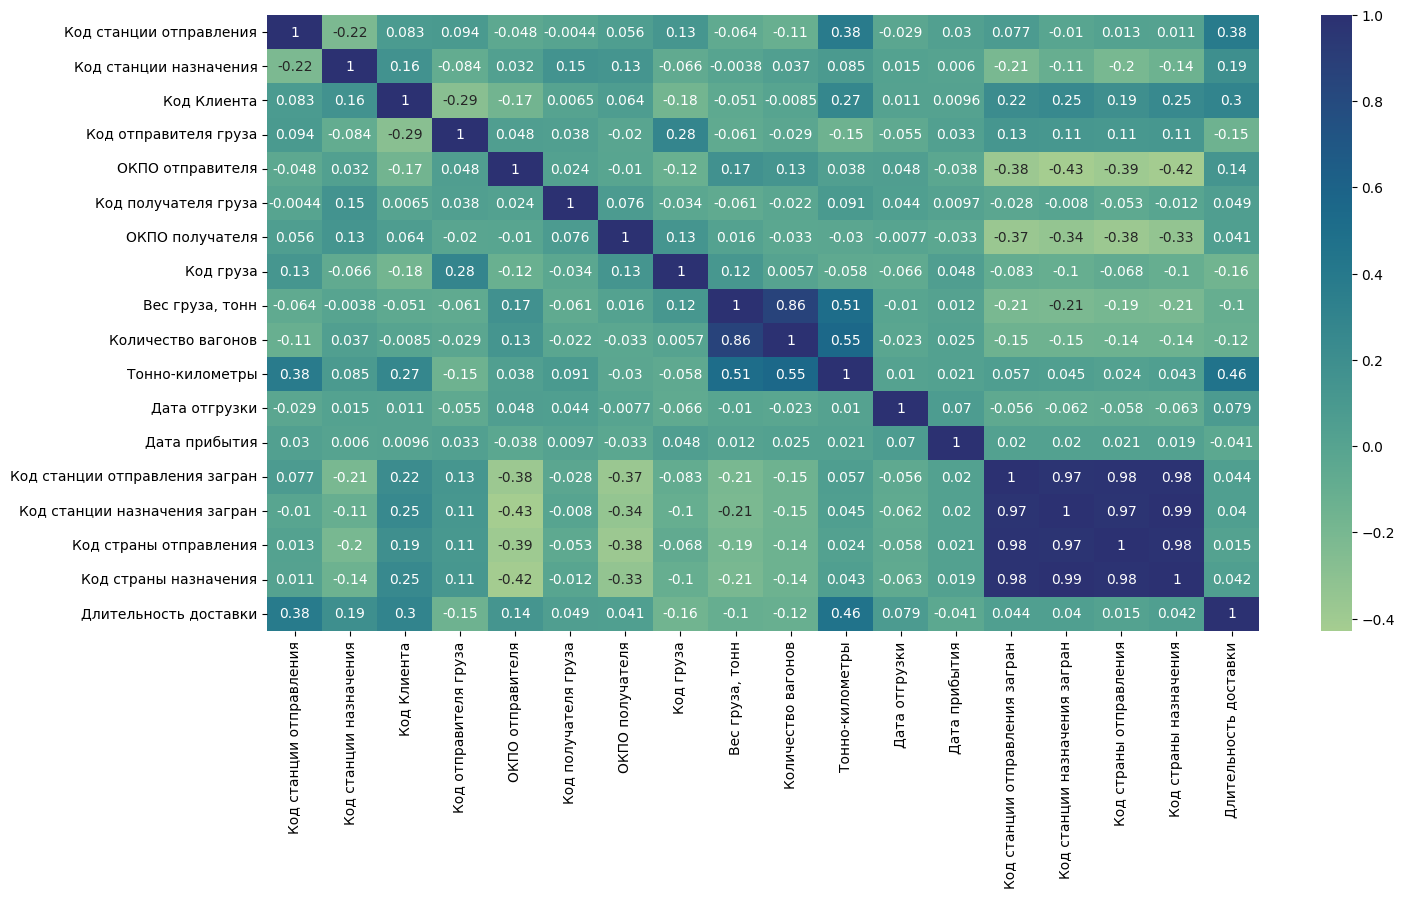

In [13]:
heat = main_df.corr(numeric_only=True, method='spearman')
plt.figure(figsize=[16, 8])
sns.heatmap(heat, cmap='crest', annot=True)

In [14]:
fig = px.treemap(main_df, path=[px.Constant('Отгрузка'), 'Ж/Д отгрузки', 'Отд. ж/д отгрузки', 'Станция отправления'], width=1200, height=800)
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.show()

In [15]:
fig = px.treemap(main_df, path=[px.Constant('Поставка'), 'Ж/Д поставки', 'Отд. ж/д поставки', 'Станция назначения'])
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.show()

[Text(0, 0.5, 'Средняя длительность доставки')]

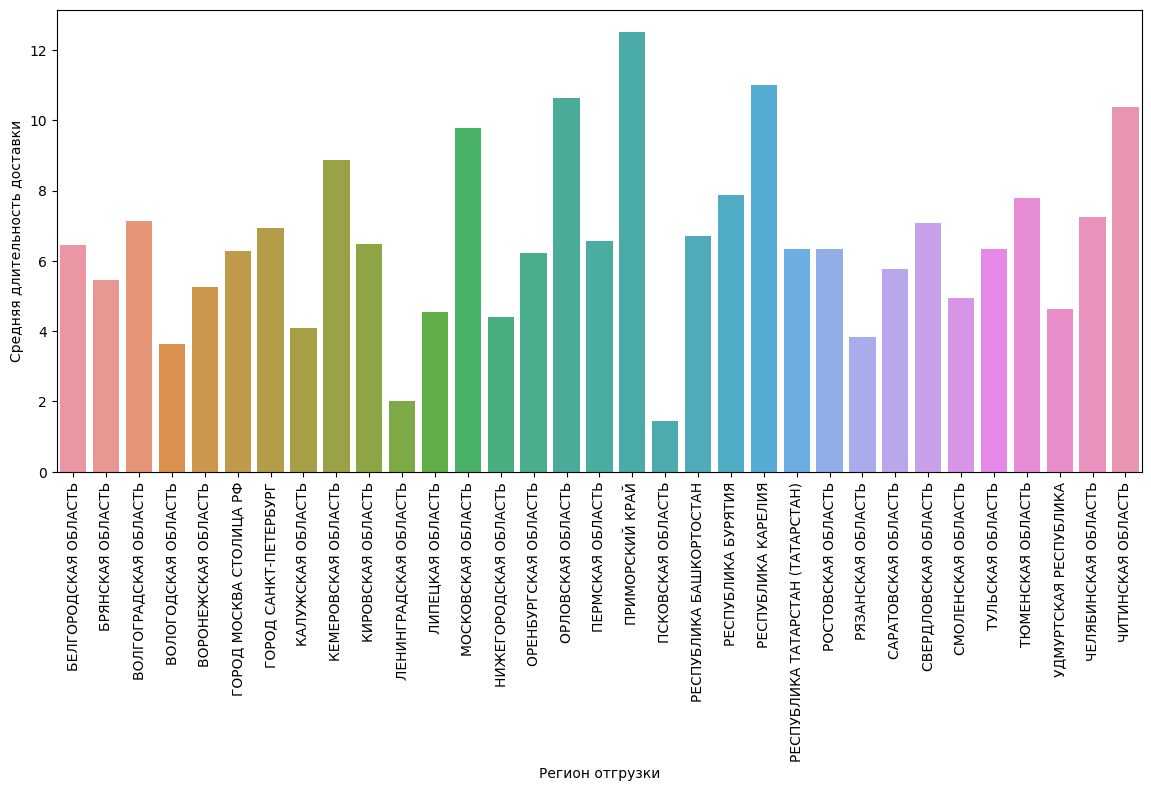

In [16]:
code_duration = main_df.groupby(by='Регион отгрузки')['Длительность доставки'].mean()
data = code_duration.reset_index()
fig = plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
bars=sns.barplot(data=data, x='Регион отгрузки', y='Длительность доставки')
bars.set(ylabel='Средняя длительность доставки')

[Text(0, 0.5, 'Средняя длительность доставки')]

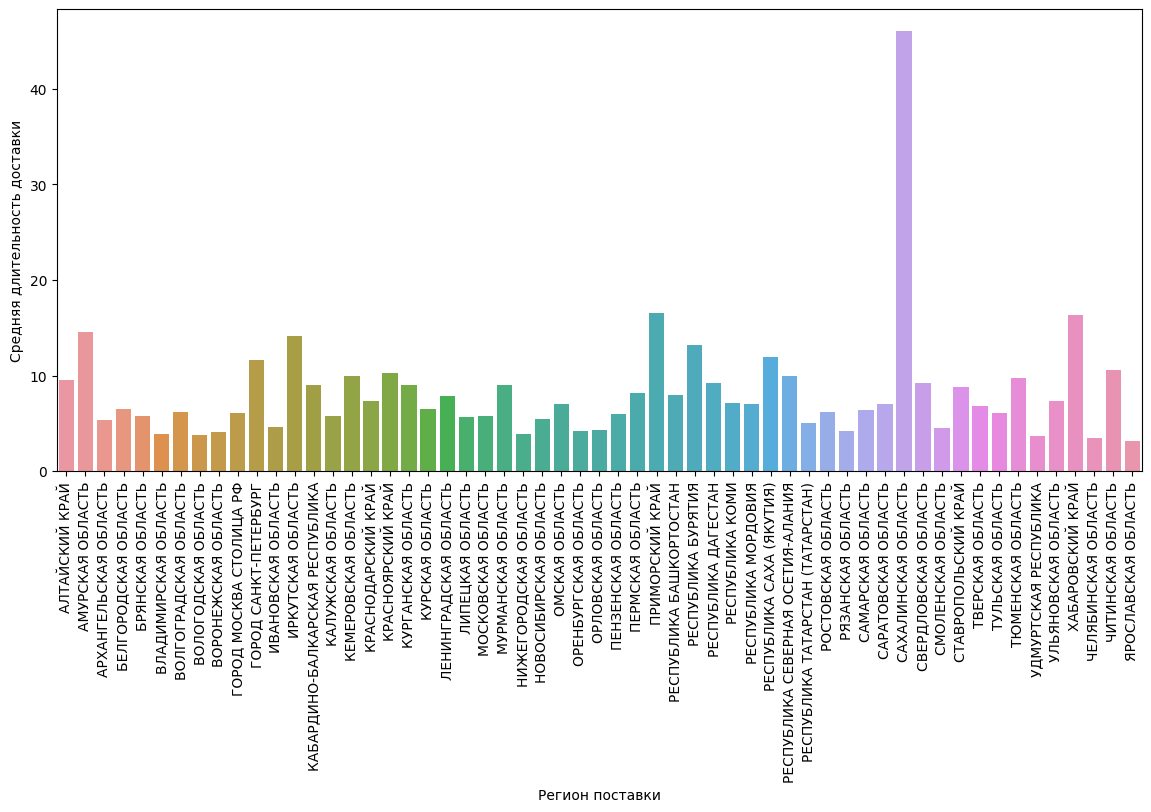

In [17]:
code_duration = main_df.groupby(by='Регион поставки')['Длительность доставки'].mean()
data = code_duration.reset_index()
fig = plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
bars=sns.barplot(data=data, x='Регион поставки', y='Длительность доставки')
bars.set(ylabel='Средняя длительность доставки')

<Axes: xlabel='Тонно-километры'>

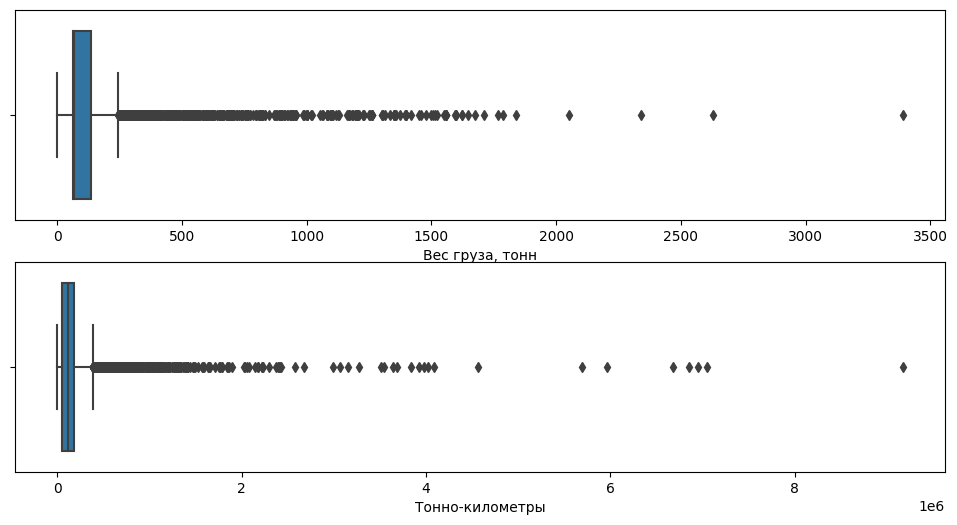

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.boxplot(data=main_df, x='Вес груза, тонн', ax=axes[0])
sns.boxplot(data=main_df, x='Тонно-километры', ax=axes[1])

In [19]:
main_df

,Код станции отправления,Станция отправления,Регион отгрузки,Ж/Д отгрузки,Отд. ж/д отгрузки,Код станции назначения,Станция назначения,Регион поставки,Ж/Д поставки,Отд. ж/д поставки,...,Характер перевозок,Станция отправления загран,Код станции отправления загран,Станция назначения загран,Код станции назначения загран,Код страны отправления,Страна отправления,Код страны назначения,Страна назначения,Длительность доставки
0,98080,МЫС-ЧУРКИН,ПРИМОРСКИЙ КРАЙ,Дальневосточная,ВЛАДИВОСТ-ОЕ,23880,ВЕРБИЛКИ,МОСКОВСКАЯ ОБЛАСТЬ,Московская,МОСК-ЯРОСЛАВ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,22
1,18180,КУНЦЕВО II,ГОРОД МОСКВА СТОЛИЦА РФ,Московская,МОСК-СМОЛЕHС,97000,ХАБАРОВСК II,ХАБАРОВСКИЙ КРАЙ,Дальневосточная,ХАБАРОВСКОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,26
2,18180,КУНЦЕВО II,ГОРОД МОСКВА СТОЛИЦА РФ,Московская,МОСК-СМОЛЕHС,97000,ХАБАРОВСК II,ХАБАРОВСКИЙ КРАЙ,Дальневосточная,ХАБАРОВСКОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,16
3,18020,ОЧАКОВО I,ГОРОД МОСКВА СТОЛИЦА РФ,Московская,МОСК-СМОЛЕHС,84010,БАРНАУЛ,АЛТАЙСКИЙ КРАЙ,Западно-Сибирская,АЛТАЙСКОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,8
4,18020,ОЧАКОВО I,ГОРОД МОСКВА СТОЛИЦА РФ,Московская,МОСК-СМОЛЕHС,85120,НОВОСИБИРСК-ЗАПАДНЫЙ,НОВОСИБИРСКАЯ ОБЛАСТЬ,Западно-Сибирская,HОВОСИБИР-ОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7388,20000,БРЯНСК-ЛЬГОВСКИЙ,БРЯНСКАЯ ОБЛАСТЬ,Московская,БРЯHСКОЕ,21580,СТАЛЬНОЙ КОНЬ,ОРЛОВСКАЯ ОБЛАСТЬ,Московская,ОРЛОВСКОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,2
7389,20000,БРЯНСК-ЛЬГОВСКИЙ,БРЯНСКАЯ ОБЛАСТЬ,Московская,БРЯHСКОЕ,17440,ВЯЗЬМА-БРЯНСКАЯ,СМОЛЕНСКАЯ ОБЛАСТЬ,Московская,СМОЛЕHСКОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,2
7390,20000,БРЯНСК-ЛЬГОВСКИЙ,БРЯНСКАЯ ОБЛАСТЬ,Московская,БРЯHСКОЕ,17440,ВЯЗЬМА-БРЯНСКАЯ,СМОЛЕНСКАЯ ОБЛАСТЬ,Московская,СМОЛЕHСКОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,2
7391,23820,ПОВАРОВО II,МОСКОВСКАЯ ОБЛАСТЬ,Московская,МОСК-ЯРОСЛАВ,20000,БРЯНСК-ЛЬГОВСКИЙ,БРЯНСКАЯ ОБЛАСТЬ,Московская,БРЯHСКОЕ,...,Внутр. пер,00000,0,00000,0,0,РОССИЯ,0,РОССИЯ,1


In [20]:
main_df.groupby(by='Страна назначения')['Код страны назначения'].count()
main_df.groupby(by='Страна отправления')['Код страны назначения'].count()

Страна отправления
АВСТРИЯ                 21
БЕЛАРУСЬ               161
ВЕНГРИЯ                  4
ГЕРМАНИЯ                71
КАЗАХСТАН              232
КИТАЙ                  115
КОРЕЯ (РЕСПУБЛИКА)      10
ЛИТВА                    2
ПОЛЬША                  17
РОССИЯ                6497
СИНГАПУР                 1
ТАИЛАНД                  4
УКРАИНА                245
ФРАНЦИЯ                  1
ЧЕХИЯ                    6
ШВЕЦИЯ                   1
ЯПОНИЯ                   5
Name: Код страны назначения, dtype: int64

## Подготовка данных

### Удаляем не нужные столбцы

Пропуски и дубликаты мы обработали ранее

In [21]:
main_df.columns

Index(['Код станции отправления', 'Станция отправления', 'Регион отгрузки',
       'Ж/Д отгрузки', 'Отд. ж/д отгрузки', 'Код станции назначения',
       'Станция назначения', 'Регион поставки', 'Ж/Д поставки',
       'Отд. ж/д поставки', 'Код Клиента', 'Клиент', 'Код отправителя груза',
       'ОКПО отправителя', 'Отправитель', 'Код получателя груза',
       'ОКПО получателя', 'Получатель', 'Код груза', 'Наименование груза',
       'Вес груза, тонн', 'Количество вагонов', 'Тонно-километры',
       'Дата отгрузки', 'Дата прибытия', 'Характер перевозок',
       'Станция отправления загран', 'Код станции отправления загран',
       'Станция назначения загран', 'Код станции назначения загран',
       'Код страны отправления', 'Страна отправления', 'Код страны назначения',
       'Страна назначения', 'Длительность доставки'],
      dtype='object')

In [22]:
main_df.drop(columns=['Станция отправления', 'Станция назначения', 'Клиент', 
             'ОКПО отправителя', 'Отправитель', 'ОКПО получателя', 'Получатель',
             'Наименование груза', 'Дата отгрузки', 'Дата прибытия', 'Станция отправления загран',
             'Станция назначения загран', 'Страна отправления', 'Страна назначения', 'Ж/Д отгрузки', 'Ж/Д поставки',
             'Код станции отправления загран', 'Код станции назначения загран', 'Код страны отправления', 'Код страны назначения'], inplace=True)

C:\Users\solod\AppData\Local\Temp\ipykernel_12184\2737621336.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Преобразуем типы переменных и создаём целевую переменную

In [23]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7393 entries, 0 to 7392
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Код станции отправления  7393 non-null   int64  
 1   Регион отгрузки          7393 non-null   object 
 2   Отд. ж/д отгрузки        7393 non-null   object 
 3   Код станции назначения   7393 non-null   int64  
 4   Регион поставки          7393 non-null   object 
 5   Отд. ж/д поставки        7393 non-null   object 
 6   Код Клиента              7393 non-null   int64  
 7   Код отправителя груза    7393 non-null   int64  
 8   Код получателя груза     7393 non-null   int64  
 9   Код груза                7393 non-null   int64  
 10  Вес груза, тонн          7393 non-null   float64
 11  Количество вагонов       7393 non-null   int64  
 12  Тонно-километры          7393 non-null   int64  
 13  Характер перевозок       7393 non-null   object 
 14  Длительность доставки   

In [24]:
prep_df = main_df.astype({'Код станции отправления': 'object',
'Код станции назначения': 'object', 'Код Клиента': 'object', 'Код отправителя груза': 'object',
'Код получателя груза': 'object', 'Код груза': 'object'})

In [25]:
prep_df['target'] = np.where(prep_df['Длительность доставки'] > 2, 1, 0)

In [26]:
for col in prep_df:
    if prep_df[col].dtype == pd.Categorical:
        print(col, len(prep_df[col].unique()))

Код станции отправления 119
Регион отгрузки 33
Отд. ж/д отгрузки 45
Код станции назначения 291
Регион поставки 57
Отд. ж/д поставки 77
Код Клиента 118
Код отправителя груза 128
Код получателя груза 469
Код груза 40
Характер перевозок 4


### Удаляем выбросы и масштабируем числовые перемнные

<Axes: xlabel='Тонно-километры'>

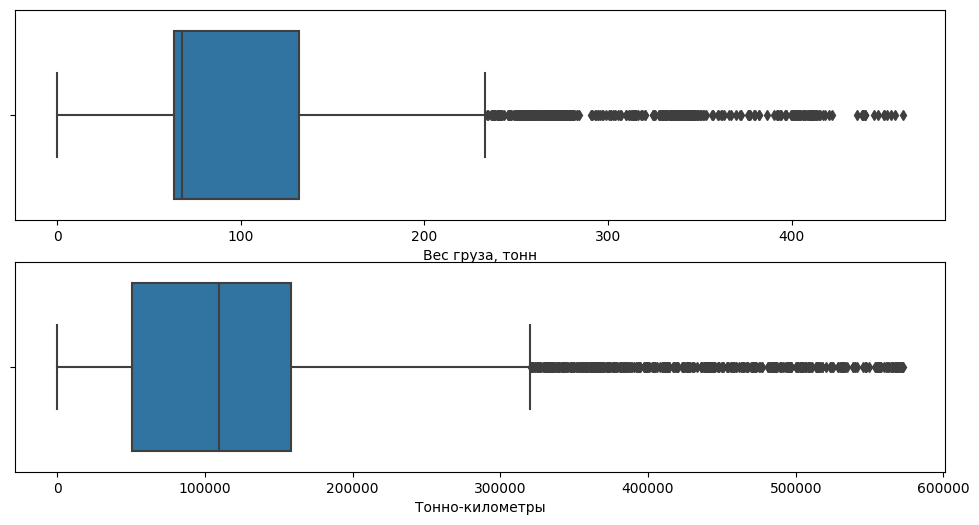

In [27]:
cols = ['Вес груза, тонн', 'Тонно-километры']

Q = prep_df[cols].quantile(0.95)

prep_df[cols] = prep_df[cols][prep_df[cols] < Q]
prep_df.dropna(inplace=True)
prep_df.reset_index(drop=True, inplace=True)

prep_df = prep_df.astype({'Тонно-километры': 'int64', 'Количество вагонов': 'int64'})

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.boxplot(data=prep_df, x='Вес груза, тонн', ax=axes[0])
sns.boxplot(data=prep_df, x='Тонно-километры', ax=axes[1])

<Axes: xlabel='Тонно-километры'>

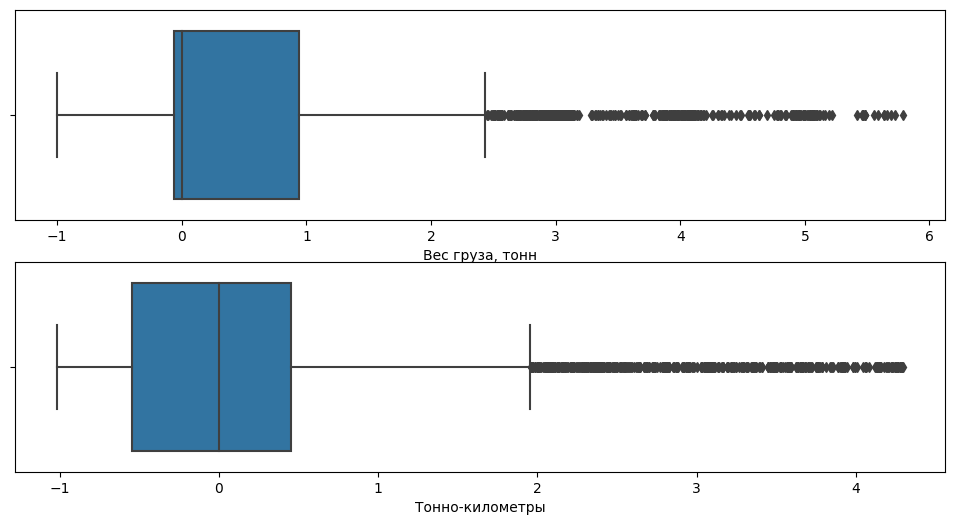

In [28]:
scaler = RobustScaler()
# mm_scaler = MinMaxScaler()
prep_df[cols] = scaler.fit_transform(prep_df[cols])
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.boxplot(data=prep_df, x='Вес груза, тонн', ax=axes[0])
sns.boxplot(data=prep_df, x='Тонно-километры', ax=axes[1])

In [29]:
prep_df

,Код станции отправления,Регион отгрузки,Отд. ж/д отгрузки,Код станции назначения,Регион поставки,Отд. ж/д поставки,Код Клиента,Код отправителя груза,Код получателя груза,Код груза,"Вес груза, тонн",Количество вагонов,Тонно-километры,Характер перевозок,Длительность доставки,target
0,18180,ГОРОД МОСКВА СТОЛИЦА РФ,МОСК-СМОЛЕHС,97000,ХАБАРОВСКИЙ КРАЙ,ХАБАРОВСКОЕ,1000061282,1768,3653,32410,-0.924313,1,-0.605267,Внутр. пер,26,1
1,18180,ГОРОД МОСКВА СТОЛИЦА РФ,МОСК-СМОЛЕHС,97000,ХАБАРОВСКИЙ КРАЙ,ХАБАРОВСКОЕ,1000061282,1768,3653,32410,-0.909573,1,-0.525870,Внутр. пер,16,1
2,18020,ГОРОД МОСКВА СТОЛИЦА РФ,МОСК-СМОЛЕHС,84010,АЛТАЙСКИЙ КРАЙ,АЛТАЙСКОЕ,1000076381,1325,335,32411,0.002756,1,1.209230,Внутр. пер,8,1
3,43960,БЕЛГОРОДСКАЯ ОБЛАСТЬ,БЕЛГОРОДСКОЕ,18020,ГОРОД МОСКВА СТОЛИЦА РФ,МОСК-СМОЛЕHС,1000076381,5110,1325,32411,0.968531,2,-0.049175,Импорт,3,1
4,43960,БЕЛГОРОДСКАЯ ОБЛАСТЬ,БЕЛГОРОДСКОЕ,18020,ГОРОД МОСКВА СТОЛИЦА РФ,МОСК-СМОЛЕHС,1000076381,5110,1325,32411,-0.042302,1,-0.545446,Импорт,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,17000,СМОЛЕНСКАЯ ОБЛАСТЬ,СМОЛЕHСКОЕ,17010,СМОЛЕНСКАЯ ОБЛАСТЬ,СМОЛЕHСКОЕ,7000094095,294,294,32106,1.947527,4,-1.008391,Внутр. пер,0,0
6820,17010,СМОЛЕНСКАЯ ОБЛАСТЬ,СМОЛЕHСКОЕ,17000,СМОЛЕНСКАЯ ОБЛАСТЬ,СМОЛЕHСКОЕ,7000094095,294,294,32106,1.947527,4,-1.008391,Внутр. пер,0,0
6821,23810,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-ЯРОСЛАВ,19370,ГОРОД МОСКВА СТОЛИЦА РФ,МОСК-КУРСКОЕ,7000094095,312,110,32105,0.738890,59,-0.634843,Внутр. пер,7,1
6822,23820,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-ЯРОСЛАВ,20000,БРЯНСКАЯ ОБЛАСТЬ,БРЯHСКОЕ,7000094095,312,312,32105,1.711696,8,-0.310800,Внутр. пер,1,0


### Делим данные на выборки

In [30]:
X = prep_df[['Код станции отправления', 'Регион отгрузки', 'Отд. ж/д отгрузки',
       'Код станции назначения', 'Регион поставки', 'Отд. ж/д поставки',
       'Код Клиента', 'Код отправителя груза', 'Код получателя груза',
       'Код груза', 'Вес груза, тонн', 'Тонно-километры', 'Количество вагонов',
       'Характер перевозок']]

y = prep_df[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4776, 14), (2048, 14), (4776, 1), (2048, 1))

#### Создадим ещё одну выборку, в которую включим все строки с целевой переменной равной 0 и столько же строк с 1

In [31]:
prep_df.drop(axis=1, labels='Длительность доставки', inplace=True)
test_0 = prep_df[(prep_df['target']==0)]
test_1 = prep_df[(prep_df['target']==1)].sample(n=426)
test10 = pd.concat([test_0, test_1], ignore_index = True)
test_0_y = test10['target']
test_0_x = test10.drop(axis=1, labels='target')

### Устраняем дисбаланс целевой переменной

Делаяем это только на тренировочной выборке, чтобы тестировать модель на реальных данных, а не на сгенерированных

<Axes: xlabel='index', ylabel='target'>

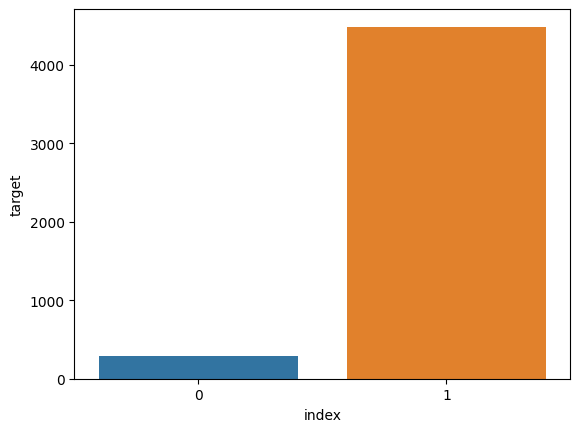

In [32]:
prescaled_df = X_train.assign(target = y_train)
xx = prescaled_df['target'].value_counts().reset_index()
sns.barplot(data=xx, x='index', y='target')

<Axes: >

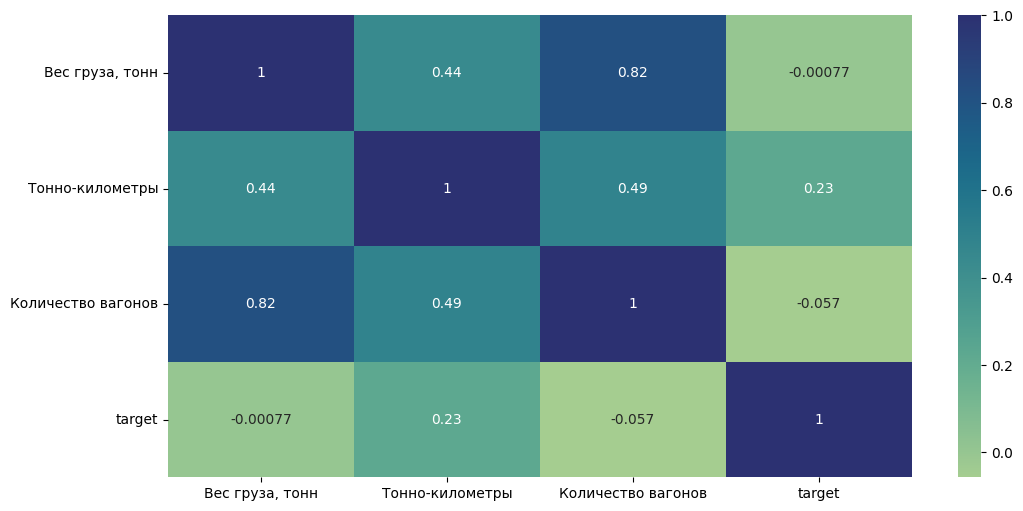

In [33]:
heat = prescaled_df.corr(numeric_only=True, method='spearman')
plt.figure(figsize=[12, 6])
sns.heatmap(heat, cmap='crest', annot=True)

In [34]:
sm = SMOTENC(categorical_features = ['Код станции отправления', 'Регион отгрузки', 'Отд. ж/д отгрузки',
       'Код станции назначения', 'Регион поставки', 'Отд. ж/д поставки',
       'Код Клиента', 'Код отправителя груза', 'Код получателя груза',
       'Код груза', 'Характер перевозок'])
X_train, y_train = sm.fit_resample(X_train, y_train)

<Axes: >

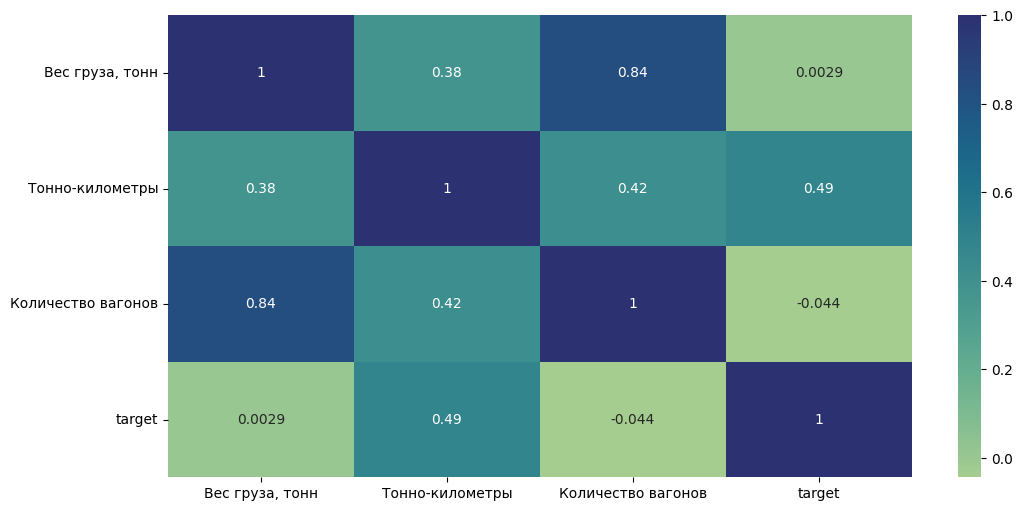

In [35]:
upscaled_df = X_train.assign(target = y_train)

heat = upscaled_df.corr(numeric_only=True, method='spearman')
plt.figure(figsize=[12, 6])
sns.heatmap(heat, cmap='crest', annot=True)

<Axes: xlabel='index', ylabel='target'>

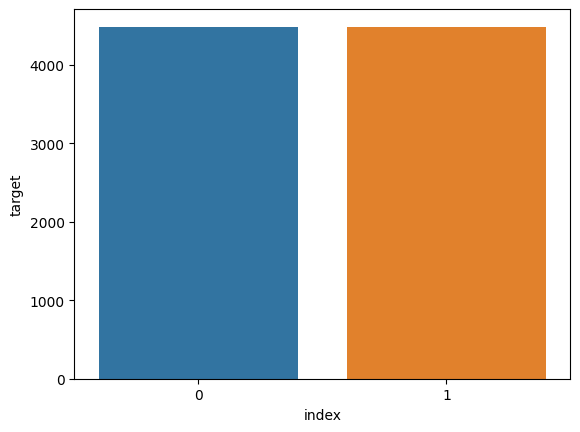

In [36]:
xx = upscaled_df['target'].value_counts().reset_index()
sns.barplot(data=xx, x='index', y='target')

## AutoML

Мы будем использовать модуль H2O

In [37]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\Users\solod\AppData\Local\Programs\Python\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\solod\AppData\Local\Temp\tmp53jgeh31
  JVM stdout: C:\Users\solod\AppData\Local\Temp\tmp53jgeh31\h2o_solod_started_from_python.out
  JVM stderr: C:\Users\solod\AppData\Local\Temp\tmp53jgeh31\h2o_solod_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_solod_erxo52
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.911 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [38]:
exp_test = X_test.assign(target = y_train)

In [39]:
train_hf = h2o.H2OFrame(upscaled_df)
test_hf = h2o.H2OFrame(X_test)
test_for_exp = h2o.H2OFrame(exp_test)
test_hf_custom = h2o.H2OFrame(test_0_x)
train_hf['target'] = train_hf['target'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [40]:
train_hf

Код станции отправления,Регион отгрузки,Отд. ж/д отгрузки,Код станции назначения,Регион поставки,Отд. ж/д поставки,Код Клиента,Код отправителя груза,Код получателя груза,Код груза,"Вес груза, тонн",Тонно-километры,Количество вагонов,Характер перевозок,target
59220,ЛИПЕЦКАЯ ОБЛАСТЬ,ЕЛЕЦКОЕ,19430,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-РЯЗАHСК,1.00023e+09,7363,2506,32416,0.0101702,-0.693969,1,Внутр. пер,1
30250,ВОЛОГОДСКАЯ ОБЛАСТЬ,ВОЛОГОДСКОЕ,22970,МОСКОВСКАЯ ОБЛАСТЬ,КАШИРСКОЕ,1.00023e+09,5010,5638,32415,0.534483,-0.291252,2,Внутр. пер,1
30250,ВОЛОГОДСКАЯ ОБЛАСТЬ,ВОЛОГОДСКОЕ,18810,КАЛУЖСКАЯ ОБЛАСТЬ,СМОЛЕHСКОЕ,1.00023e+09,5010,3871,32416,-0.210332,-0.577713,1,Внутр. пер,1
59220,ЛИПЕЦКАЯ ОБЛАСТЬ,ЕЛЕЦКОЕ,23760,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-КУРСКОЕ,1.00023e+09,7363,9733,32416,-0.115852,-0.692902,1,Внутр. пер,1
30250,ВОЛОГОДСКАЯ ОБЛАСТЬ,ВОЛОГОДСКОЕ,23790,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-ЯРОСЛАВ,1.00023e+09,5010,3892,32415,5.6895,1.6791,8,Внутр. пер,1
59220,ЛИПЕЦКАЯ ОБЛАСТЬ,ЕЛЕЦКОЕ,19080,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-КУРСКОЕ,1.00023e+09,7363,5667,32416,0.0101702,-0.686964,1,Внутр. пер,1
23670,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-ЯРОСЛАВ,77540,СВЕРДЛОВСКАЯ ОБЛАСТЬ,СЕРОВСКОЕ,1.00011e+09,3431,7828,32307,-0.60678,-0.536447,1,Внутр. пер,1
81760,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,КАРТАЛИHСКОЕ,19480,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-РЯЗАHСК,1.00135e+09,5010,1240,32418,1.88916,2.82539,3,Внутр. пер,1
3160,ГОРОД САНКТ-ПЕТЕРБУРГ,ЛЕHИH-МОСК-Е,23670,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-ЯРОСЛАВ,1.0056e+09,9570,3431,32416,1.77415,0.751498,3,Внутр. пер,1
24360,НИЖЕГОРОДСКАЯ ОБЛАСТЬ,МУРОМСКОЕ,19100,МОСКОВСКАЯ ОБЛАСТЬ,МОСК-КУРСКОЕ,1.00578e+09,3437,5796,32305,-0.0303633,-0.785027,1,Внутр. пер,1


In [41]:
aml = H2OAutoML(
    max_runtime_secs=100,
    include_algos=['DRF', 'GLM', 'GBM', 'DeepLearning']
)

aml.train(
    x=list(X_train.columns),
    y='target',
    training_frame=train_hf
)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20231226_233114_model_8


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    81                 81                          421431                 11           17           16.8272       69            652           373.839

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.007648348499004413
RMSE: 0.08745483691028423
LogLoss: 0.03609356165039155
Mean Per-Class Error: 0.006905769659166852
AUC: 0.9997999615009011
AUCPR: 0.9998047009435636
Gini: 0.9995999230018022

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37957127860944423
       0     1     Error    Rate
-----  ----  ----  -------  -------------
0      4458  31    0.0069   (31.0/4489.0)
1      31    4458  0.0069   (31.0/4489.0)
Total  4489  4489  0.0069   (62.0/8978.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379571     0.993094  207
max f2                       0.317955     0.994172  221
max f0point5                 0.566595     0.995568  168
max accuracy                 0.388782     0.993094  206
max precision                0.999783     1         0
max recall                   0.0740403    1         309
max specificity              0.999783     1         0
max absolute_mcc             0.388782     0.986189  206
max min_per_class_accuracy   0.379571     0.993094  207
max mean_per_class_accuracy  0.388782     0.993094  206
max tns                      0.999783     4489      0
max fns                      0.999783     3959      0
max fps                      0.000364661  4489      399
max tps                      0.0740403    4489      309
max tnr                      0.999783     1         0
max fnr                      0.999783     0.881934  0
max fpr                      0.000364661  1         399
max tpr                      0.0740403    1         309

Gains/Lift Table: Avg response rate: 50,00 %, avg score: 50,01 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100245                   0.999808           2          2                  1                0.999827     1                           0.999827            0.020049        0.020049                   100       100                0.020049
2        0.020049                    0.999793           2          2                  1                0.9998       1                           0.999813            0.020049        0.040098                   100       100                0.040098
3        0.0300735                   0.999781           2          2                  1                0.999787     1                           0.999804            0.020049        0.060147                   100       100                0.060147
4        0.0402094                   0.999767           2          2                  1                0.999774     1                           0.999797            0.0202718       0.0804188                  100       100                0.0804188
5        0.0500111                   0.999754           2          2                  1                0.999761     

In [42]:
lb = aml.leaderboard 
lb.head(rows = lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20231226_233114_model_8,0.990804,0.110595,0.992265,0.0356427,0.171736,0.0294934
GBM_4_AutoML_1_20231226_233114,0.990356,0.112146,0.991953,0.0347516,0.171152,0.0292931
GBM_3_AutoML_1_20231226_233114,0.990169,0.114824,0.991702,0.0354199,0.174081,0.030304
GBM_grid_1_AutoML_1_20231226_233114_model_7,0.99009,0.113795,0.991754,0.0358654,0.172883,0.0298887
GBM_2_AutoML_1_20231226_233114,0.99009,0.114575,0.99163,0.0366451,0.174061,0.0302972
GBM_grid_1_AutoML_1_20231226_233114_model_1,0.989813,0.115602,0.99158,0.037759,0.175479,0.0307928
DRF_1_AutoML_1_20231226_233114,0.989523,0.130963,0.991126,0.0368679,0.180742,0.0326676
GBM_5_AutoML_1_20231226_233114,0.989445,0.117181,0.991332,0.0369793,0.176048,0.030993
GBM_grid_1_AutoML_1_20231226_233114_model_2,0.989416,0.116739,0.99107,0.0361996,0.174976,0.0306167
GBM_grid_1_AutoML_1_20231226_233114_model_9,0.989326,0.120424,0.990941,0.0374248,0.177742,0.0315923


### Результаты AutoML

In [43]:
# automl = h2o.get_model('GBM_grid_1_AutoML_1_20231206_215550_model_15')

In [44]:
preds = aml.predict(test_hf)
preds_df = h2o.as_list(preds, use_pandas=True)
preds_df

gbm prediction progress: |

███████████████████████████████████████████████████████| (done) 100%


c:\Users\solod\AppData\Local\Programs\Python\Python310\lib\site-packages\h2o\job.py:81: UserWarning:

Test/Validation dataset column 'Регион поставки' has levels not trained on: ["КУРГАНСКАЯ ОБЛАСТЬ", "РЕСПУБЛИКА МОРДОВИЯ", "САХАЛИНСКАЯ ОБЛАСТЬ"]

c:\Users\solod\AppData\Local\Programs\Python\Python310\lib\site-packages\h2o\job.py:81: UserWarning:

Test/Validation dataset column 'Отд. ж/д поставки' has levels not trained on: ["БЕЛОВСКОЕ", "КАВКАЗСКОЕ", "КУРГАHСКОЕ", "ЛЕHИH-ФИHЛЯH", "МУРОМСКОЕ", "РЖЕВСКОЕ", "РУЗАЕВСКОЕ", "ЮЖ-САХАЛИH-Е"]



,predict,p0,p1
0,1,0.000285,0.999715
1,1,0.025297,0.974703
2,1,0.001913,0.998087
3,1,0.006726,0.993274
4,1,0.005021,0.994979
...,...,...,...
2043,1,0.027589,0.972411
2044,1,0.013279,0.986721
2045,1,0.000333,0.999667
2046,1,0.000210,0.999790


In [45]:
accuracy = accuracy_score(y_test, preds_df['predict'])
cf_matrix = confusion_matrix(y_test, preds_df['predict'])
automl_f1 = f1_score(y_test, preds_df['predict'])
accuracy, automl_f1

(0.927734375, 0.9611752360965372)

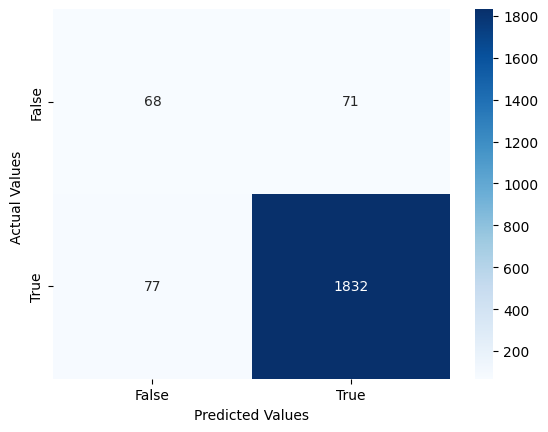

In [46]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.4g')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [61]:
preds = aml.predict(test_hf_custom)
preds_df = h2o.as_list(preds, use_pandas=True)
preds_df

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1
0,0,0.778380,0.221620
1,1,0.015672,0.984328
2,0,0.975563,0.024437
3,0,0.863727,0.136273
4,0,0.971282,0.028718
...,...,...,...
847,1,0.000250,0.999750
848,1,0.000914,0.999086
849,1,0.007520,0.992480
850,1,0.048037,0.951963


In [62]:
accuracy = accuracy_score(test_0_y, preds_df['predict'])
cf_matrix = confusion_matrix(test_0_y, preds_df['predict'])
automl_f1 = f1_score(test_0_y, preds_df['predict'])
accuracy, automl_f1

(0.8814553990610329, 0.8933474128827879)

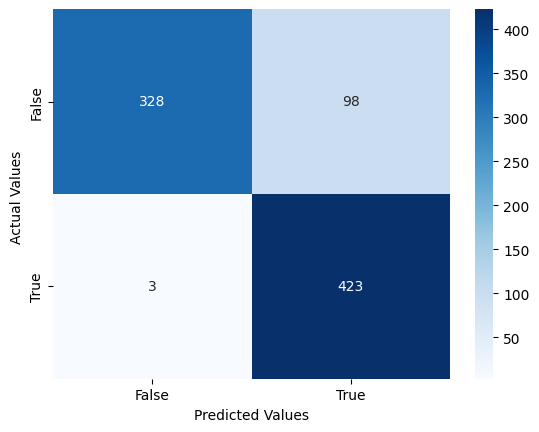

In [63]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.4g')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## Моделирование

In [47]:
cat_features = list(X_train.select_dtypes(include=['object']).columns)
model = CatBoostClassifier(loss_function='Logloss',
                            cat_features=cat_features,
                            task_type='GPU',
                            random_seed=63,
                            iterations=600,
                            learning_rate=0.1,
                            boosting_type='Plain',
                            bootstrap_type='Bernoulli',
                            one_hot_max_size=5,
                            random_strength=1,
                            l2_leaf_reg=3,
                            early_stopping_rounds=20,
                            leaf_estimation_method='Newton')



model.fit(X_train, y_train, plot=True, verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5637702	total: 45.5ms	remaining: 27.3s
100:	learn: 0.1035692	total: 3.11s	remaining: 15.4s
200:	learn: 0.0807628	total: 6.98s	remaining: 13.8s
300:	learn: 0.0669411	total: 11s	remaining: 10.9s
400:	learn: 0.0597161	total: 14.8s	remaining: 7.35s
500:	learn: 0.0522189	total: 18.7s	remaining: 3.7s
599:	learn: 0.0469709	total: 22.5s	remaining: 0us


In [48]:
preds_class = model.predict(X_test)

In [49]:
cat_accuracy = accuracy_score(y_test, preds_class)
cat_cf_matrix = confusion_matrix(y_test, preds_class)
cat_f1 = f1_score(y_test, preds_class)
cat_accuracy, cat_f1

(0.92333984375, 0.9586079620353283)

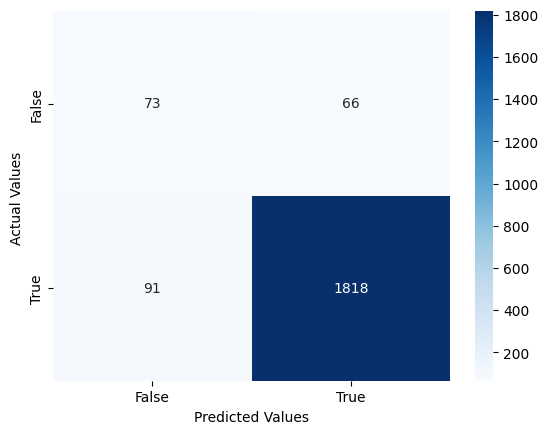

In [50]:
ax = sns.heatmap(cat_cf_matrix, annot=True, cmap='Blues', fmt='.4g')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [64]:
preds_class2 = model.predict(test_0_x)

cat_accuracy2 = accuracy_score(test_0_y, preds_class2)
cat_cf_matrix2 = confusion_matrix(test_0_y, preds_class2)
cat_f12 = f1_score(test_0_y, preds_class2)
cat_accuracy2, cat_f12

(0.8603286384976526, 0.8746048472075869)

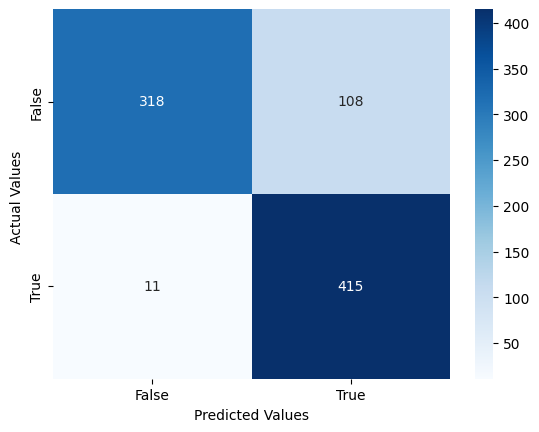

In [65]:
ax = sns.heatmap(cat_cf_matrix2, annot=True, cmap='Blues', fmt='.4g')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## Интерпритация модели

### Глобальная интерпритация CatBoost

In [54]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_test.columns).sort_values()

<BarContainer object of 14 artists>

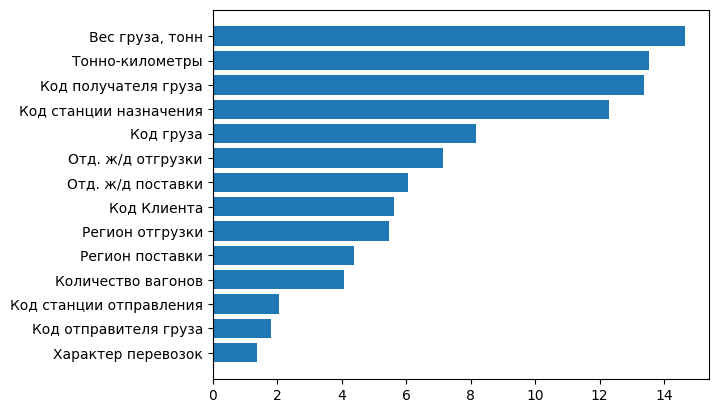

In [55]:
plt.barh(feature_importances.index, feature_importances.values)
# sns.barplot(x=feature_importances.values, y=feature_importances.index)

In [56]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

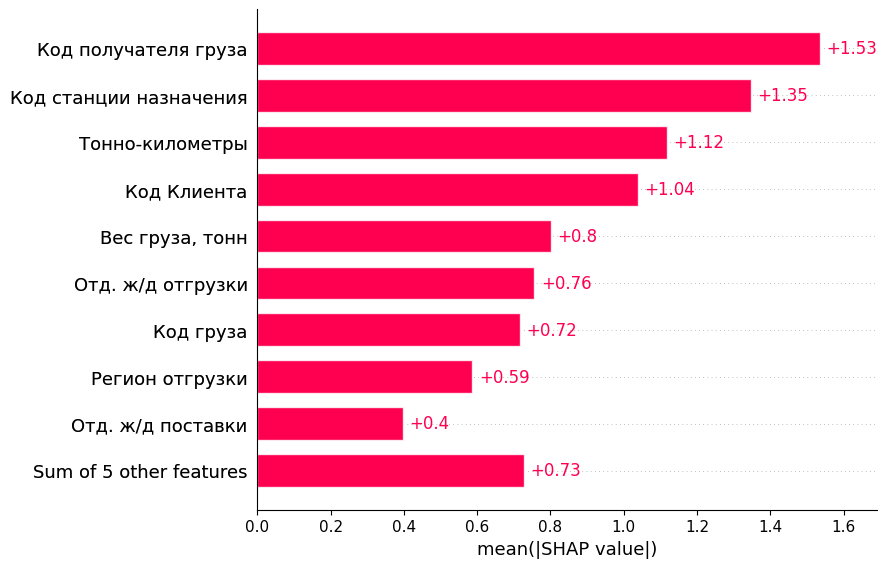

In [57]:
shap.plots.bar(shap_values)

### Локальная интерпритация CatBoost

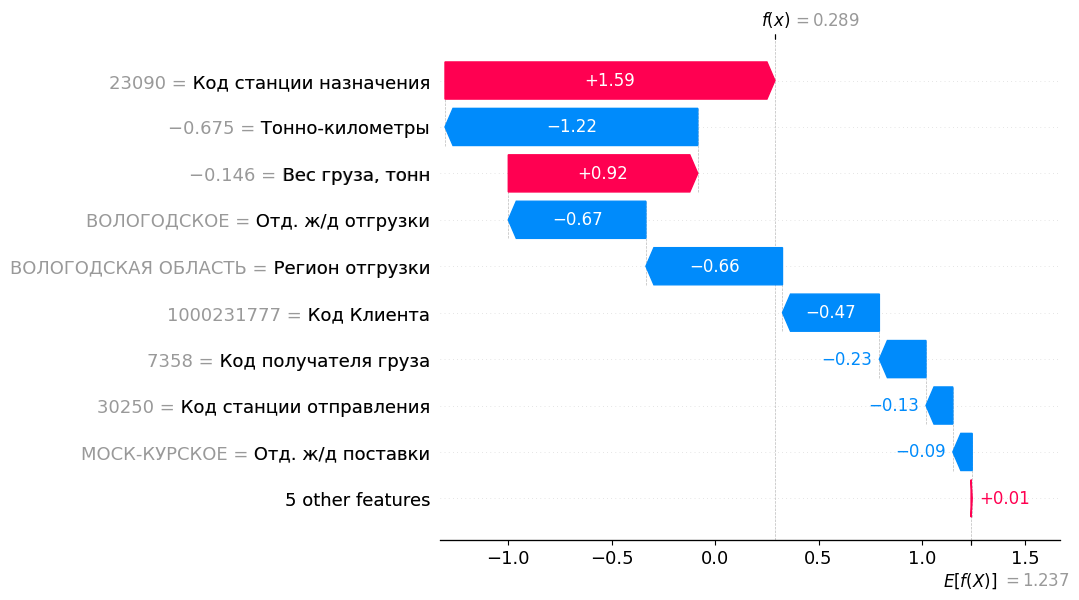

In [58]:
shap.plots.waterfall(shap_values[5])

### Глобальная интерпритация H2O

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

c:\Users\solod\AppData\Local\Programs\Python\Python310\lib\site-packages\h2o\job.py:81: UserWarning:

Test/Validation dataset column 'Регион поставки' has levels not trained on: ["КУРГАНСКАЯ ОБЛАСТЬ", "РЕСПУБЛИКА МОРДОВИЯ", "САХАЛИНСКАЯ ОБЛАСТЬ"]

c:\Users\solod\AppData\Local\Programs\Python\Python310\lib\site-packages\h2o\job.py:81: UserWarning:

Test/Validation dataset column 'Отд. ж/д поставки' has levels not trained on: ["БЕЛОВСКОЕ", "КАВКАЗСКОЕ", "КУРГАHСКОЕ", "ЛЕHИH-ФИHЛЯH", "МУРОМСКОЕ", "РЖЕВСКОЕ", "РУЗАЕВСКОЕ", "ЮЖ-САХАЛИH-Е"]



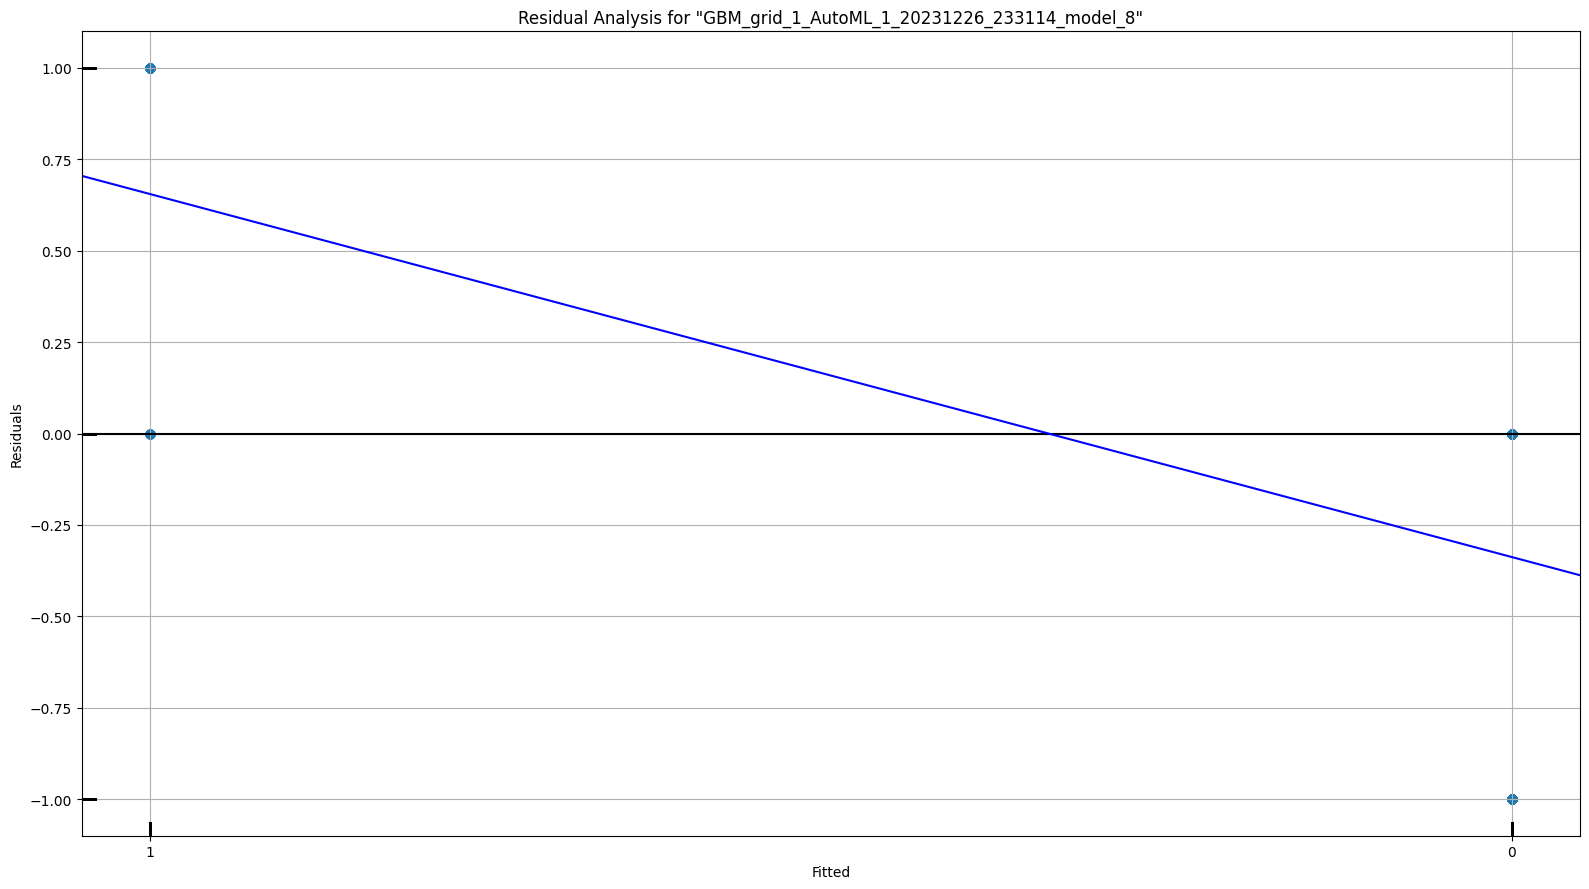

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

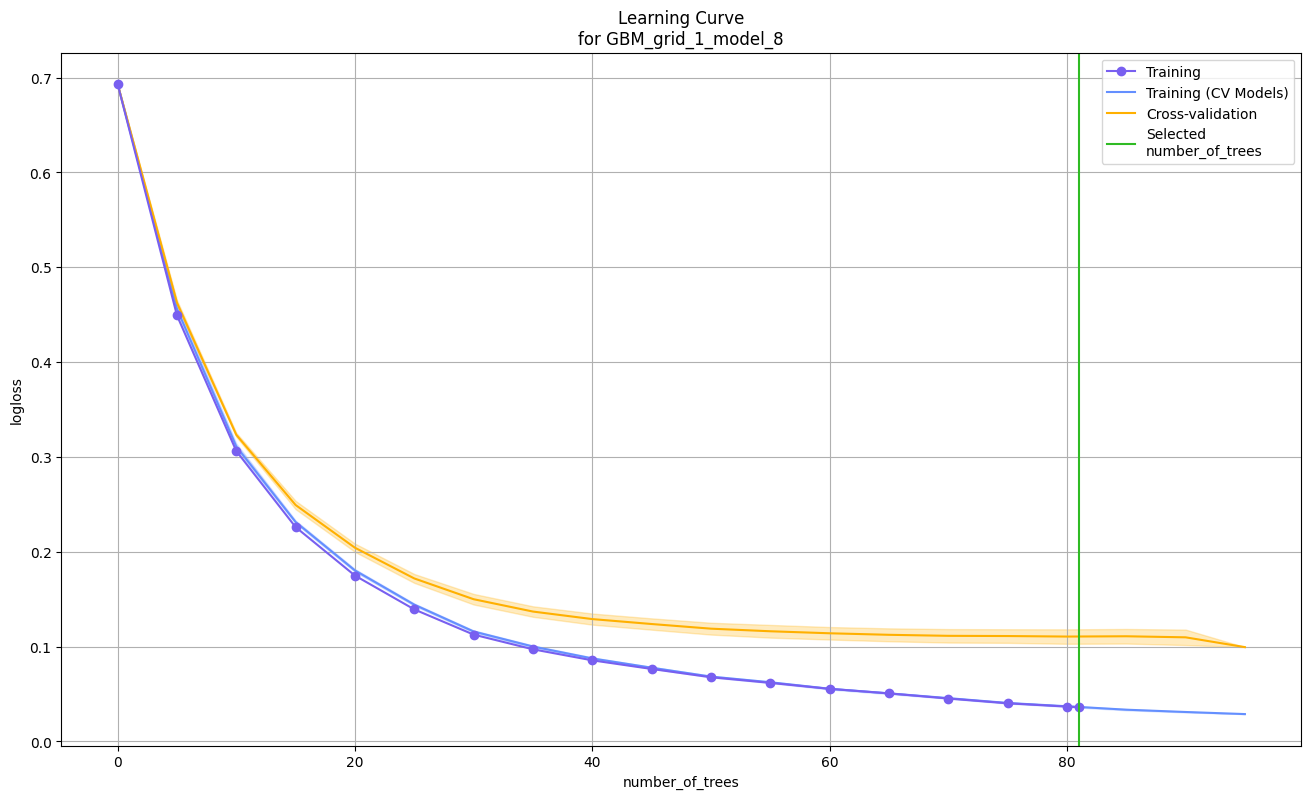

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

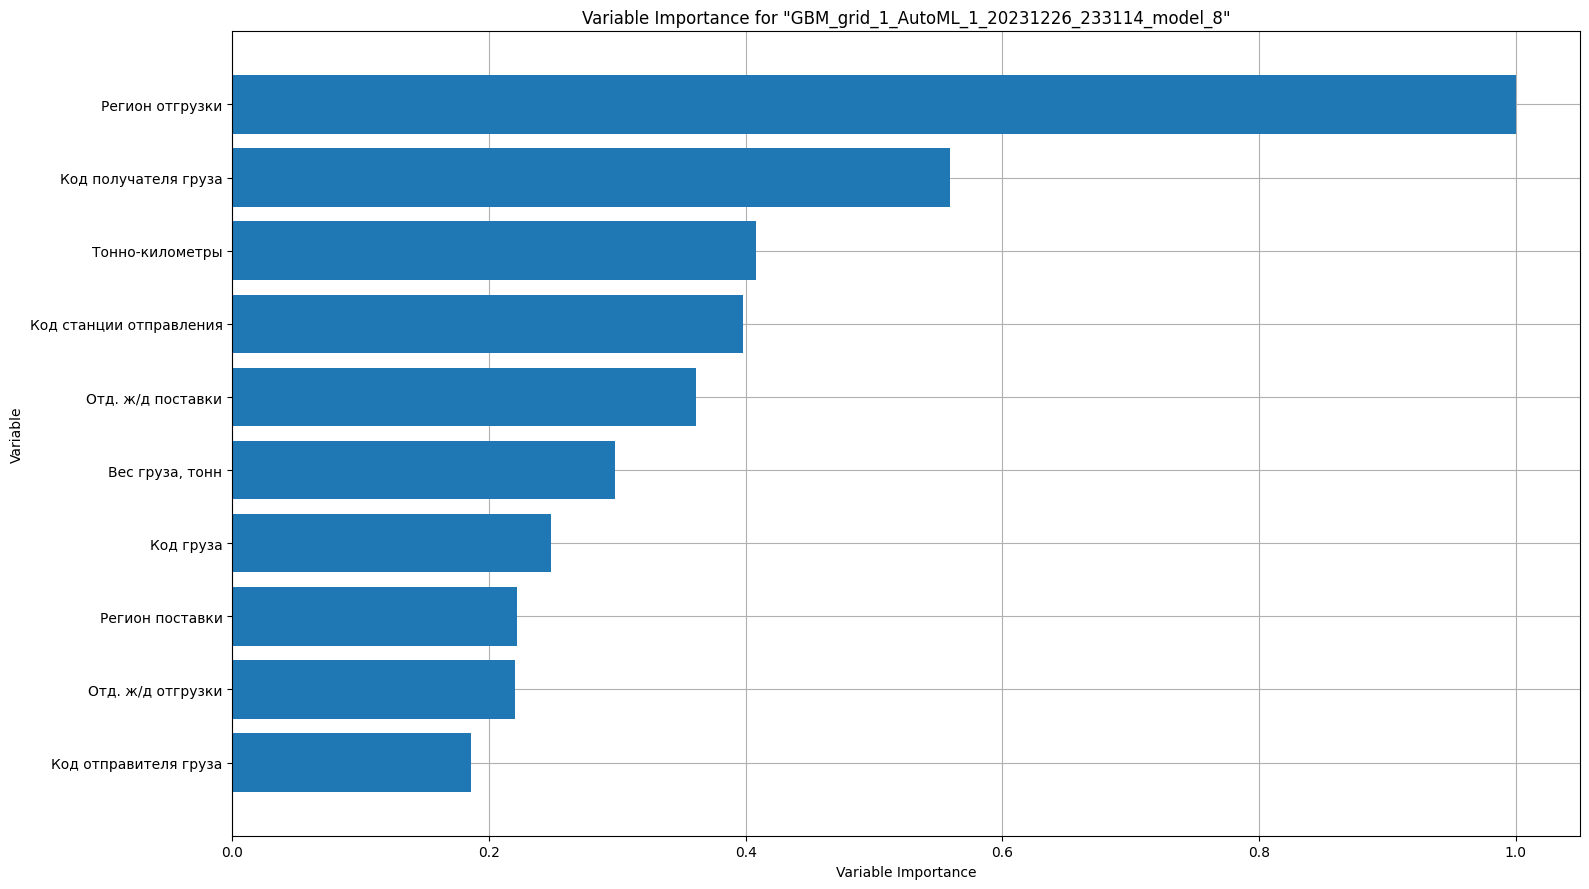

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

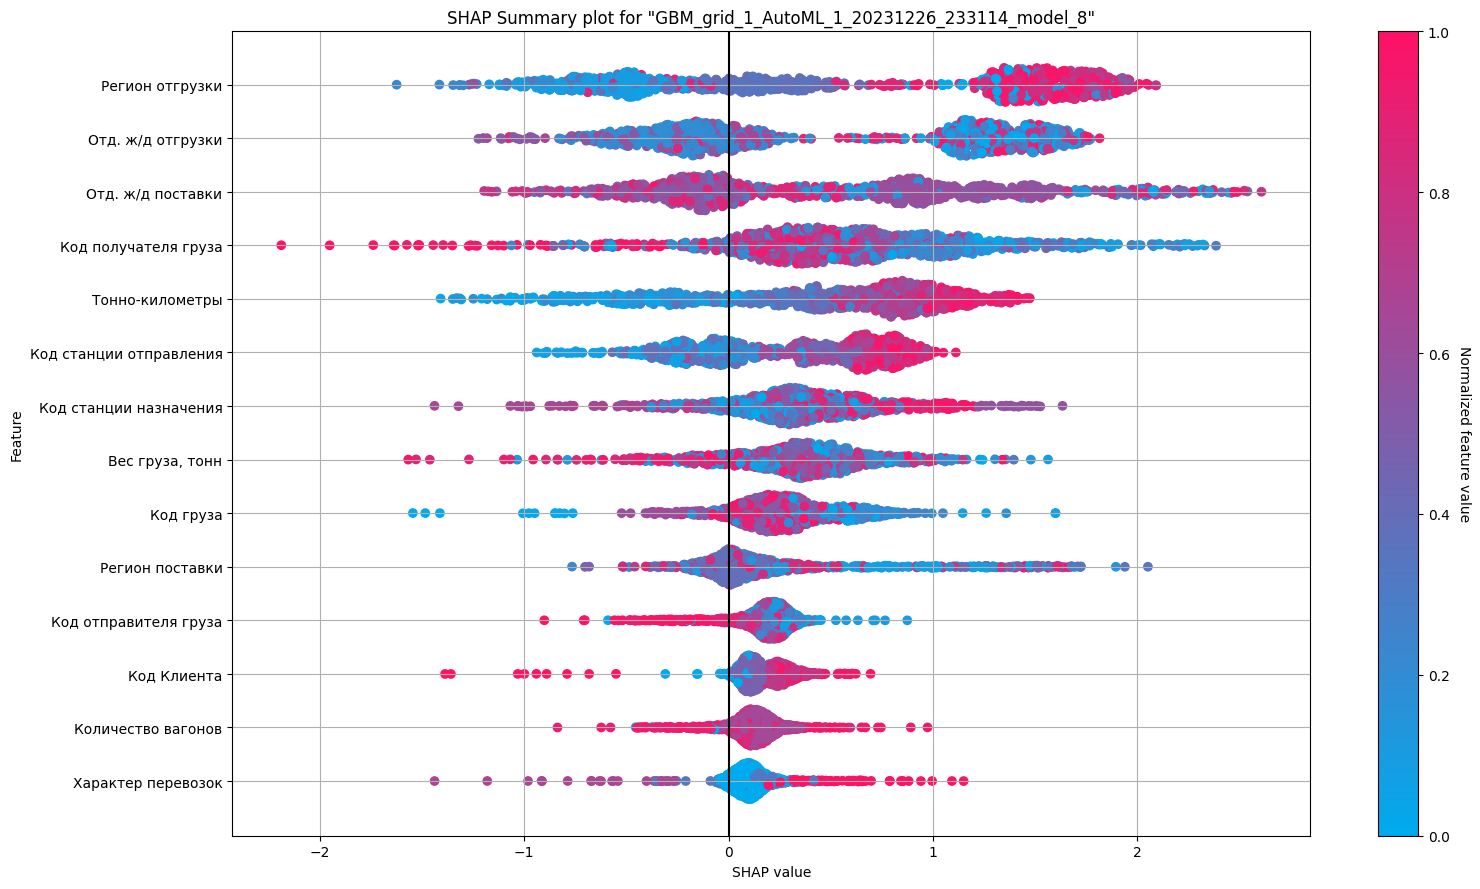

In [59]:
exa = aml.leader.explain(test_for_exp,
                        exclude_explanations=['pdp', 'ice'])    